<table><tr>
<td> 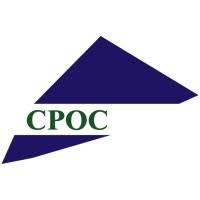 </td>
<td> <img src="https://npc-core.com/npc-content/uploads/2021/03/core-analysis-cores-combo.jpeg" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

<h1 align=center><font size = 4> Munish Kumar </font></h1>
<h1 align=center><font size = 4> P5628_MTJA_CCS_Feasibility </font></h1>
<h1 align=center><font size = 4> Routine Core Analysis </font></h1>
<h1 align=center><font size = 3> ERCE 2022 </font></h1>

#### Libraries

In [1]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes
#!pip install sympy --user

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

# Sklearn Liraries
from sklearn import preprocessing

# For Latex style text
from sympy import S, symbols, printing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

# Display max rows
pd.set_option('display.max_rows', 500)

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


###### Declare some global variables

In [2]:
dir_name = r'C:\Users\mkumar\Documents\GitHub\munishkumar-gh.github.io\Core_Analysis_CPOC'
filename_suffix = 'csv'

# Font, marker size and axis rotation
edgecolors = 'black'
markersize = 16
alpha = 0.5
size = 18
rotation = 0

###### Series of Functions

In [3]:
# Function to look at first 5 and last 5 elements in a dataframe
def ends(df, x=5):
    return df.head(x).append(df.tail(x))
setattr(pd.DataFrame,'ends',ends)

In [4]:
# Function to read out file
def file_out(df, dir_name, base_filename, filename_suffix):
    try:
        csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
        df.to_csv(csvs_sht, index = False, header=True)
        print ("Final File Extract Produced")
    except IOError:
        print("I/O error")
    return

In [5]:
# Function to search for a text string
def search_words(text):
    result = re.findall(r'\b[^\d\W]+\b', text)
    return " ".join(result)

In [6]:
# Function to plot grain density
def plot_grain_density(mod_df, title, bins, xmin, xmax, savefn):
    sns.set()
    sns.set_style("whitegrid")     
    sns.set_style("ticks", 
                  {"xtick.major.size":size,
                  "ytick.major.size":size}
                 )
    sns.axes_style("whitegrid")
    kwargs = {'cumulative': True}

    ax = sns.distplot(mod_df, 
                      bins = bins, 
                      kde=False, 
                      norm_hist=False, 
                      color = 'r',
                      #bw_adjust=.25,
                      #hist_kws=kwargs, 
                      #kde_kws=kwargs
                     )

    ax.set(ylabel='Frequency', 
           #xlabel='common ylabel',
           xlim = (xmin, xmax),
          )

    ax.legend(labels=['Histogram', 'Frequency'])
    plt.title(title)
    plt.grid(True)

    plt.savefig(savefn, transparent=True)
    return

In [7]:
# Plotting the effect of NOBP
def plot_NOBP(mod_df, df_sub, grouped, color, savefn):
    # Plot per group
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(121)

    for i, (name, group) in enumerate(grouped):
        sc = ax.scatter(
            group["NOB (psi)"],
            group["Porosity (%)"],
            s = markersize**2,
            alpha=0.5,
            label=name,
            edgecolors = edgecolors,
        )  

    # Add legends (one for gender, other for size)
    ax.add_artist(ax.legend(title='Well Name'))
    ax.legend(*sc.legend_elements("colors", num=6))
    ax.set_xlabel('Net Overburden Pressure (psi)', fontsize=size)
    ax.set_ylabel('Porosity (%)', fontsize=size)

    plt.xticks(rotation = rotation, fontsize=size)
    plt.yticks(rotation = rotation, fontsize=size)
    plt.ylim(0,20) 
    plt.grid(True)
    
    ax1 = fig.add_subplot(122)

    for i, (name, group) in enumerate(grouped):
        sc1 = ax1.scatter(
            group["NOB (psi)"],
            group["K_klin (mD)"],
            s = markersize**2,
            alpha=0.5,
            label=name,
            edgecolors = edgecolors,
        )  

    # Add legends 
    ax1.add_artist(ax1.legend(title='Well Name'))
    ax1.legend(*sc1.legend_elements("colors", num=6))
    ax1.set_xlabel('Net Overburden Pressure (psi)', fontsize=size)
    ax1.set_ylabel('Permeability (mD)', fontsize=size)

    plt.xticks(rotation = rotation, fontsize=size)
    plt.yticks(rotation = rotation, fontsize=size)
    #plt.ylim(0,20)

    plt.tight_layout()
    plt.grid(True)

    plt.savefig(savefn, transparent=True)
    return

In [8]:
def plot_PP(df_sub, grouped, color, title, savefn, xint1, yint1, xint2, yint2, xlimit, ylimit, plot_line_eqn):
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111)

    for i, (name, group) in enumerate(grouped):
        sc = ax.scatter(
            group["Porosity (%)"],
            group["K_klin (mD)"],
            s = markersize**2,
            alpha=0.5,
            label=name,
            edgecolors = edgecolors,
        )  

    # Add legends
    ax.add_artist(ax.legend(title='Well Name'))
    ax.legend(*sc.legend_elements("colors", num=6), prop={'size': 20})
    ax.set_xlabel('Porosity (%)', fontsize=size)
    ax.set_ylabel('Permeability (mD)', fontsize=size)

    plt.xticks(rotation = rotation, fontsize=size)
    plt.yticks(rotation = rotation, fontsize=size)
    plt.xlim(0, xlimit)
    plt.ylim(0.01, ylimit)
    
    df_sub = df_sub[['Porosity (%)', 'K_klin (mD)']].sort_values(by = 'Porosity (%)', ascending = True)
    
    # Fit to linear-log
    y1 = df_sub["Porosity (%)"] #x-value
    y2 = df_sub["K_klin (mD)"] #y-value 
   
    ## Eqn Fit 1 ##
    # For fitting y = Ax^B, ln y = ln A + B ln x. So fit (ln y) against (ln x).
    #p = np.polyfit(np.log(y1), np.log(y2), 1, w=np.sqrt(y2/2)) # w is weight to bias against larger values of y
    p = np.polyfit(np.log(y1), np.log(y2), 1)
    f = np.poly1d(p)

    ## Eqn Fit 2 ##
    # For fitting y = Ae^(Bx), ln y = ln A + Bx. So fit (ln y) against x.
    #p = np.polyfit(y1, np.log(y2), 1, w=np.sqrt(y2)) # w is weight to bias against larger values of y
    #p = np.polyfit(y1, np.log(y2), 1)
    #f = np.poly1d(p)

    if plot_line_eqn == True: 
        ax.semilogy(y1, np.exp(p[0] * np.log(y1) + p[1]), 'k--', linewidth = 2.5)
        #Display Equation
        #plt.text(17.5, 100, r'Equation ={}'.format(f), fontsize = size,bbox=dict(facecolor='white', alpha=0.25))
        #plt.title (title, fontsize = size)
    else:
        p[0] = 0
        p [1] = 0
        f = np.poly1d(p)
    
    # here we add the vertical and horizontal line 1
    plt.axvline(x=xint1, color='darkorange',linestyle='--',linewidth=2)
    plt.axhline(y=yint1, color='darkorange',linestyle='--',linewidth=2)
    
    # here we add the horizontal and horizontal line 2
    plt.axvline(x=xint2, color='darkgreen',linestyle=':',linewidth=2)
    plt.axhline(y=yint2, color='darkgreen',linestyle=':',linewidth=2)

    ax.set_yscale('log')

    plt.tight_layout()
    plt.grid(True)
    
    plt.savefig(savefn, transparent=True)
    return f, p[0], p[1]

##### Read in the data and some preprocessing

In [9]:
# Header file comes preformatted as 1st row is variable name, 2nd row reads "Low, Best, High"
# Combines the first 2 rows of header into 1 header

df = pd.read_excel(
    'CoreData_CPOC.xlsx', 
    header=[0, 1], 
    sheet_name='MASTER', 
    keep_default_na=False,
    #usecols="A,C:AA"
)
df.columns=df.columns.to_flat_index()

# renaming the columns
df.columns = ['Well Name', 'Sample ID', 'Depth (m)', 'NOB (psi)', 'K_klin (mD)', 'Porosity (%)', 'Grain Density (g/cc)', 'Core Type']
df.ends(10)

C:\Users\mkumar\AppData\Local\Temp\ipykernel_8740\3237448987.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.head(x).append(df.tail(x))


,Well Name,Sample ID,Depth (m),NOB (psi),K_klin (mD),Porosity (%),Grain Density (g/cc),Core Type
0,Jengka West-1,1,2751.350,800,2.4,13.800000,2.670000,RCA
1,Jengka West-1,2,2751.650,800,9.64,15.700000,2.670000,RCA
2,Jengka West-1,3,2751.700,800,11.8,15.900000,2.670000,RCA
3,Jengka West-1,4,2751.950,800,4.03,14.500000,2.670000,RCA
4,Jengka West-1,5,2765.550,800,0.098,12.800000,2.670000,RCA
5,Jengka West-1,6,2766.750,800,3.32,16.000000,2.670000,RCA
6,Jengka West-1,7,2767.300,800,10.1,17.500000,2.670000,RCA
7,Jengka West-1,8,2767.350,800,6.5,17.500000,2.670000,RCA
8,Jengka West-1,9,2767.350,800,5.94,17.600000,2.660000,RCA
9,Jengka 2,10,2491.050,800,14.62861,22.900000,2.657000,RCA


##### Remove Missing Rows based on Missing Permeability and Porosity Values

In [10]:
df = df.replace(r'^\s*$', np.nan, regex=True)

cols = ['K_klin (mD)', 'Porosity (%)']

mod_df = df.dropna(how='any', subset=cols)
mod_df = df[df['K_klin (mD)'] > 0.01]
mod_df

,Well Name,Sample ID,Depth (m),NOB (psi),K_klin (mD),Porosity (%),Grain Density (g/cc),Core Type
0,Jengka West-1,1,2751.350,800,2.40000,13.800000,2.670000,RCA
1,Jengka West-1,2,2751.650,800,9.64000,15.700000,2.670000,RCA
2,Jengka West-1,3,2751.700,800,11.80000,15.900000,2.670000,RCA
3,Jengka West-1,4,2751.950,800,4.03000,14.500000,2.670000,RCA
4,Jengka West-1,5,2765.550,800,0.09800,12.800000,2.670000,RCA
...,...,...,...,...,...,...,...,...
799,TPA-01ST2,800,2637.048,1126,4.22000,18.995333,2.645962,RCA
800,TPA-01ST2,801,2637.768,1126,0.59000,15.035081,2.665775,RCA
801,TPA-01ST2,802,2638.918,1126,0.28000,14.408396,2.681797,RCA
802,TPA-01ST2,803,2639.898,1126,0.04000,11.206924,2.693966,RCA


###### Mapping each well to a colour

In [11]:
df_colors = pd.read_csv('https://raw.githubusercontent.com/codebrainz/color-names/master/output/colors.csv',header=None)
df_colors.columns = ['color_name', 'color_description', 'hex_value', 'r', 'g','b']

names = mod_df['Well Name'].unique()
c = df_colors[['hex_value']].astype(str).agg(','.join,axis=1).tolist()
colors = dict(zip(names,c))

mod_df['color'] = mod_df['Well Name'].apply(lambda x: colors[x])
mod_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 725 entries, 0 to 804
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Well Name             725 non-null    object 
 1   Sample ID             725 non-null    int64  
 2   Depth (m)             725 non-null    float64
 3   NOB (psi)             725 non-null    int64  
 4   K_klin (mD)           725 non-null    float64
 5   Porosity (%)          725 non-null    float64
 6   Grain Density (g/cc)  725 non-null    float64
 7   Core Type             725 non-null    object 
 8   color                 725 non-null    object 
dtypes: float64(4), int64(2), object(3)
memory usage: 56.6+ KB


C:\Users\mkumar\AppData\Local\Temp\ipykernel_8740\949046389.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_df['color'] = mod_df['Well Name'].apply(lambda x: colors[x])


In [12]:
for well in mod_df['Well Name'].unique():
        print(mod_df[mod_df['Well Name'] == well].info())      
        print(mod_df[mod_df['Well Name'] == well].describe(include='all'))       

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 0 to 8
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Well Name             9 non-null      object 
 1   Sample ID             9 non-null      int64  
 2   Depth (m)             9 non-null      float64
 3   NOB (psi)             9 non-null      int64  
 4   K_klin (mD)           9 non-null      float64
 5   Porosity (%)          9 non-null      float64
 6   Grain Density (g/cc)  9 non-null      float64
 7   Core Type             9 non-null      object 
 8   color                 9 non-null      object 
dtypes: float64(4), int64(2), object(3)
memory usage: 720.0+ bytes
None
            Well Name  Sample ID    Depth (m)  NOB (psi)  K_klin (mD)  \
count               9   9.000000     9.000000        9.0     9.000000   
unique              1        NaN          NaN        NaN          NaN   
top     Jengka West-1        NaN          NaN   

             Well Name   Sample ID    Depth (m)  NOB (psi)  K_klin (mD)  \
count               37   37.000000    37.000000       37.0    37.000000   
unique               1         NaN          NaN        NaN          NaN   
top     ANDALAS EAST-3         NaN          NaN        NaN          NaN   
freq                37         NaN          NaN        NaN          NaN   
mean               NaN  638.081081  3290.278108     3850.0     0.148740   
std                NaN   13.897199     5.101226        0.0     0.471448   
min                NaN  615.000000  3280.870000     3850.0     0.011361   
25%                NaN  626.000000  3288.810000     3850.0     0.025289   
50%                NaN  639.000000  3292.240000     3850.0     0.056739   
75%                NaN  649.000000  3293.150000     3850.0     0.092584   
max                NaN  661.000000  3298.470000     3850.0     2.898820   

        Porosity (%)  Grain Density (g/cc) Core Type    color  
count      37.000000             37

In [13]:
print(mod_df.info())
print(mod_df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 725 entries, 0 to 804
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Well Name             725 non-null    object 
 1   Sample ID             725 non-null    int64  
 2   Depth (m)             725 non-null    float64
 3   NOB (psi)             725 non-null    int64  
 4   K_klin (mD)           725 non-null    float64
 5   Porosity (%)          725 non-null    float64
 6   Grain Density (g/cc)  725 non-null    float64
 7   Core Type             725 non-null    object 
 8   color                 725 non-null    object 
dtypes: float64(4), int64(2), object(3)
memory usage: 56.6+ KB
None
        Well Name   Sample ID    Depth (m)    NOB (psi)  K_klin (mD)  \
count         725  725.000000   725.000000   725.000000   725.000000   
unique         13         NaN          NaN          NaN          NaN   
top     TPA-01ST2         NaN          NaN         

## Determine Properties based on a particular Net Overburden Pressure (NOBP) value

In [14]:
a = mod_df['NOB (psi)'].unique()
print(sorted(a))

[800, 1126, 1398, 1808, 2408, 3850]


Some of the net overburden values are missing. It will be assumed that these are ambient values i.e. 800 psi

In [15]:
mod_df['NOB (psi)'].fillna(14.7, inplace=True)
mod_df['NOB (psi)'].isnull().values.any()

C:\Users\mkumar\AppData\Local\Temp\ipykernel_8740\374934801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_df['NOB (psi)'].fillna(14.7, inplace=True)


False

#### Histogram - Plotting the Grain Density, Porosity and Permeability at Ambient (800 psi)

In [16]:
NOBP = 800

In [17]:
df_sub = mod_df[mod_df['NOB (psi)'] <= NOBP]
grouped = df_sub.groupby("Well Name")
color = df_sub['color']

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


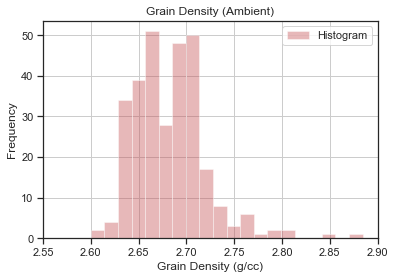

In [18]:
savefn = "Hist_GD_800.png"

## fuction to plot - usage
## plot_grain_density (dataframe_column, plot_title, number_bins, x-axis_min, x_axis_max savefile_name)
plot_grain_density(df_sub['Grain Density (g/cc)'], "Grain Density (Ambient)", 20, 2.55, 2.9, savefn)

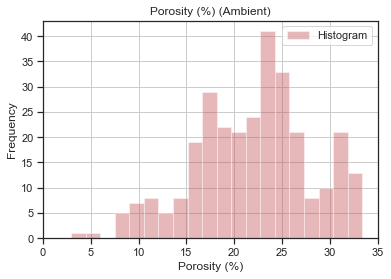

In [19]:
savefn = "Hist_Poro_800.png"
plot_grain_density(df_sub["Porosity (%)"], "Porosity (%) (Ambient)", 20, 0, 35, savefn)

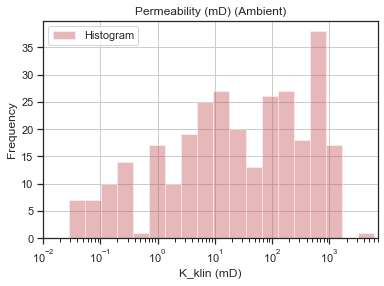

In [20]:
savefn = "Hist_Perm_800.png"

x= df_sub["K_klin (mD)"]

logbins = np.geomspace(x.min(), x.max(), 20)
plot_grain_density(df_sub["K_klin (mD)"], "Permeability (mD) (Ambient)", logbins, 0.01, x.max()+1000, savefn)
plt.xscale('log')

#### Plot cross-plot of Porosity-Permeability

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\collections.py:1099: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


Equation of line:  
6.912 x - 17.92
Intercept: 6.912264785879037
Gradient Coefficient: -17.92340371218112


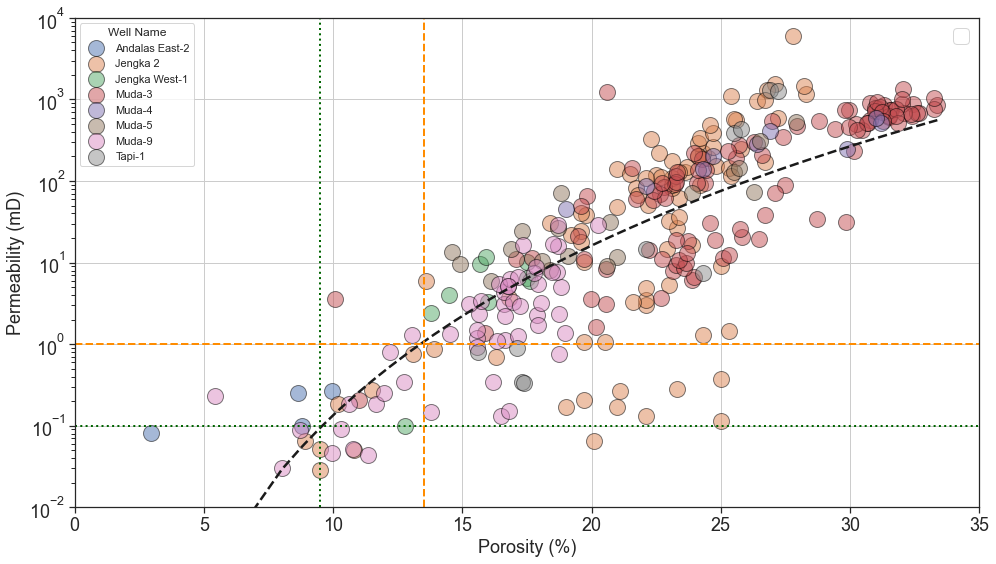

In [21]:
savefn = "Poro_Perm_800.png"

xlimit = 35
ylimit = 10000

#Cutoff intercept
yint1 = 1
xint1 = 13.5

yint2 = 0.1
xint2 = 9.5

plot_line_eqn = True

f, p0, p1 = plot_PP(df_sub, grouped, color, 
                    "Ambient Porosity vs Permeability", savefn, xint1, yint1, 
                    xint2, yint2, xlimit, ylimit, plot_line_eqn)
print("Equation of line:", f)
print("Intercept:", p0)
print("Gradient Coefficient:", p1)

##### Cross-plot for values at overburden

In [22]:
df_sub = mod_df[mod_df['NOB (psi)'] > NOBP]
grouped = df_sub.groupby("Well Name")
color = df_sub['color']

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


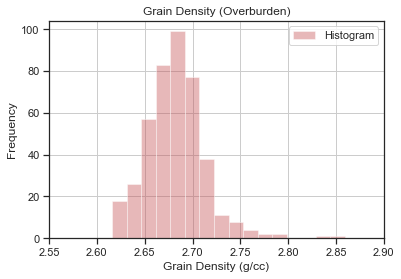

In [23]:
savefn = "Hist_GD_OB.png"

# fuction to plot - usage
# plot_grain_density (dataframe_column, plot_title, number_bins, x-axis_min, x_axis_max, savefile_name)

plot_grain_density(df_sub['Grain Density (g/cc)'], "Grain Density (Overburden)", 20, 2.55, 2.9, savefn)

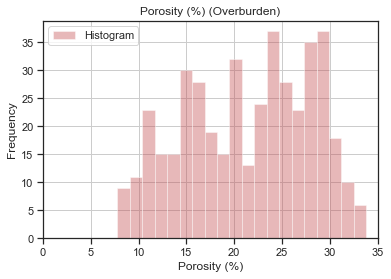

In [24]:
savefn = "Hist_Poro_OB.png"
plot_grain_density(df_sub["Porosity (%)"], "Porosity (%) (Overburden)", 20, 0, 35, savefn)

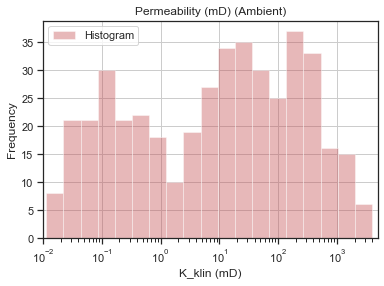

In [25]:
savefn = "Hist_Perm_OB.png"

x= df_sub["K_klin (mD)"]

logbins = np.geomspace(x.min(), x.max(), 20)
plot_grain_density(df_sub["K_klin (mD)"], "Permeability (mD) (Ambient)", logbins, 0.01, x.max()+1000, savefn)
plt.xscale('log')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\collections.py:1099: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


Equation of line:  
8.512 x - 23.53
Intercept: 8.512240911751897
Gradient Coefficient: -23.528364630250554


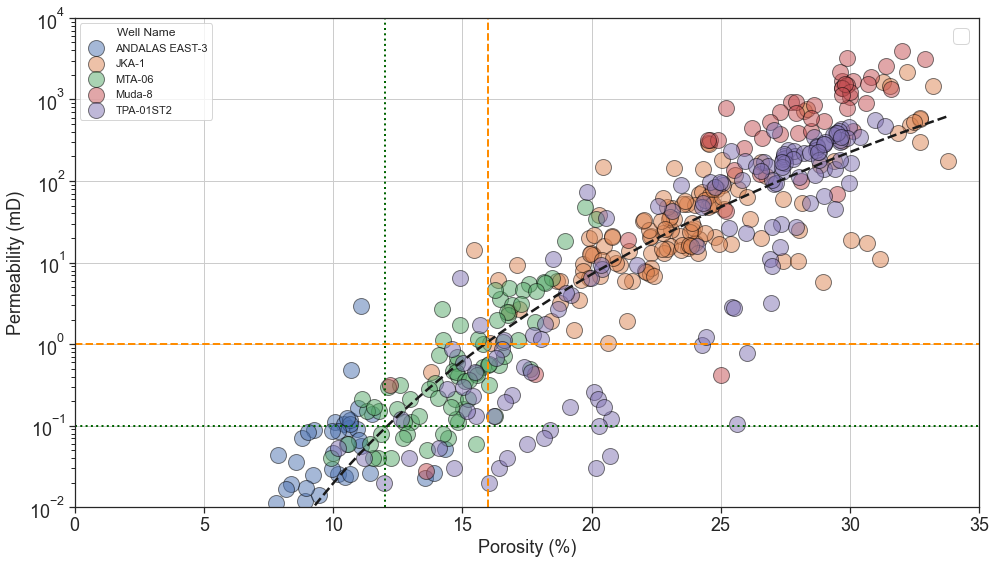

In [26]:
savefn = "Poro_Perm_Overburden.png"

xlimit = 35
ylimit = 10000

#Cutoff intercept
yint1 = 1
xint1 = 16

yint2 = 0.1
xint2 = 12

plot_line_eqn = True

f, p0, p1 = plot_PP(df_sub, grouped, color, 
                    "Overburden Porosity vs Permeability", savefn, 
                    xint1, yint1, xint2, yint2, xlimit, ylimit, plot_line_eqn)
print("Equation of line:", f)
print("Intercept:", p0)
print("Gradient Coefficient:", p1)


### K means clustering of Core Data

#### Step 1: Normalise Data Set

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#### Step 1: Elbow Plot

In [28]:
mod_df_copy = mod_df.copy()
mod_df_copy.columns.values

array(['Well Name', 'Sample ID', 'Depth (m)', 'NOB (psi)', 'K_klin (mD)',
       'Porosity (%)', 'Grain Density (g/cc)', 'Core Type', 'color'],
      dtype=object)

In [29]:
# Select columns to do prediction on
X_drop = mod_df_copy.drop(['Well Name', 'Sample ID', 'Depth (m)', 'NOB (psi)',
                           'Grain Density (g/cc)', 'Core Type', 'color'], axis = 1)

In [30]:
distortions = []

min_el = 1
max_el = 10

# A loop runs thorugh your min and max clusters. 
# We dont complicate the K-Means at this stage
# We store an "intertia" number which is the measurement of the distortions in different K clustering solutions

for i in range (min_el,max_el):
    km = KMeans(n_clusters= i, init = "k-means++")
    km.fit(X_drop)
    distortions.append(km.inertia_)  

C:\Users\mkumar\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\mkumar\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\mkumar\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\mkumar\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_

Text(0.5, 1.0, 'Elbow for KMeans clustering')

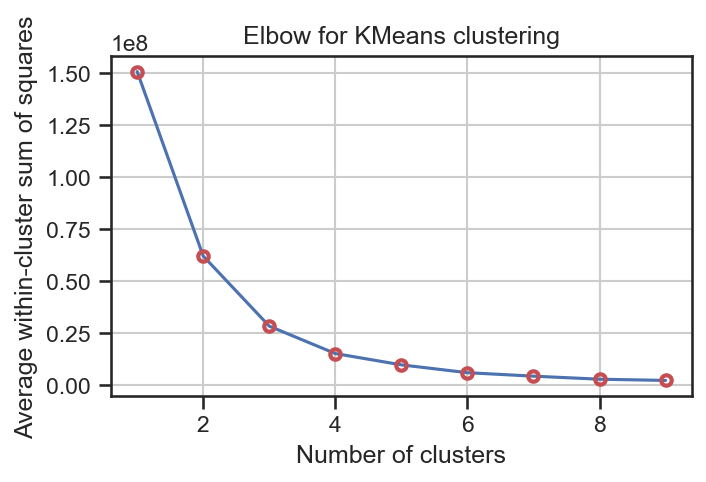

In [31]:
# elbow curve
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5,3), dpi = 150)
plt.plot(range (min_el,max_el), distortions, marker='o', markersize=5,
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

#### Looks like 4 is the optimal number of clusters. Lets do the K means proper now

#### Step 2: K-means Plot

In [32]:
# This normalizes the data set
scaler = preprocessing.StandardScaler()
scaler.fit(X_drop)
X_drop_Norm = scaler.transform(X_drop)

# Now we convert to a pandas array
#car_norm_price = pd.DataFrame(X_drop_Norm, columns = DF_model_toNorm_colnam, index = DF_model_toNorm_rownam)
#car_norm_price

In [33]:
# Fitting the K-Means with the optimal number of cluster
k = 3
km = KMeans(n_clusters=k, init = "k-means++", random_state = 0)
km_fit = km.fit(X_drop_Norm)

# Predicting the Classificaiton of the Data
y_pred = km.fit_predict(X_drop_Norm)
display(y_pred)

C:\Users\mkumar\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\mkumar\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2,
       1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 0, 0, 0,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 0, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 1, 1, 2, 2, 0,
       0, 0, 0, 0, 2, 2, 1, 1, 2, 2, 2, 0, 2, 2, 2,

In [34]:
# The predicted results should now be converted to a pandas dataframe
y_pred_data = pd.DataFrame({"cluster":y_pred},index = X_drop.index)
y_pred_data

,cluster
0,0
1,0
2,0
3,0
4,0
...,...
799,0
800,0
801,0
802,0


In [35]:
core_pred = pd.concat([X_drop , y_pred_data], axis = 1)
core_pred

,K_klin (mD),Porosity (%),cluster
0,2.40000,13.800000,0
1,9.64000,15.700000,0
2,11.80000,15.900000,0
3,4.03000,14.500000,0
4,0.09800,12.800000,0
...,...,...,...
799,4.22000,18.995333,0
800,0.59000,15.035081,0
801,0.28000,14.408396,0
802,0.04000,11.206924,0


In [36]:
names = core_pred['cluster'].unique()
c = df_colors[['hex_value']].astype(str).agg(','.join,axis=1).tolist()
colors = dict(zip(names,c))

core_pred['color'] = core_pred['cluster'].apply(lambda x: colors[x])
core_pred = core_pred.sort_values(by = 'Porosity (%)', ascending = True)
core_pred

,K_klin (mD),Porosity (%),cluster,color
434,0.081600,2.937823,0,#5d8aa8
493,0.229500,5.423839,0,#5d8aa8
641,0.011361,7.785006,0,#5d8aa8
653,0.043655,7.862623,0,#5d8aa8
514,0.030000,8.019626,0,#5d8aa8
...,...,...,...,...
317,1443.973000,33.200730,1,#72a0c1
205,1030.000000,33.260557,1,#72a0c1
172,764.206300,33.265482,2,#00308f
168,848.164000,33.376738,2,#00308f


In [37]:
pd.crosstab(core_pred['Porosity (%)'], core_pred['cluster'], normalize='index', margins = True)

cluster,0,1,2
Porosity (%),,,
2.93782304951011,1.000000,0.000000,0.000000
5.423838847610905,1.000000,0.000000,0.000000
7.78500632505322,1.000000,0.000000,0.000000
7.862623093746528,1.000000,0.000000,0.000000
8.019625723511496,1.000000,0.000000,0.000000
...,...,...,...
33.260557311117495,0.000000,1.000000,0.000000
33.265481624636564,0.000000,0.000000,1.000000
33.37673789035821,0.000000,0.000000,1.000000


In [38]:
filtered_label0 = core_pred[core_pred['cluster'] == 0]
filtered_label1 = core_pred[core_pred['cluster'] == 1]
filtered_label2 = core_pred[core_pred['cluster'] == 2]
#filtered_label3 = core_pred[core_pred['cluster'] == 3]

C:\Users\mkumar\AppData\Local\Temp\ipykernel_8740\3590831825.py:15: RuntimeWarning: divide by zero encountered in log
  plt.semilogy(x_pts, np.exp(p[0] * np.log(x_pts) + p[1]), 'k-', linewidth = 1.5)
C:\Users\mkumar\AppData\Local\Temp\ipykernel_8740\3590831825.py:20: RuntimeWarning: divide by zero encountered in log
  plt.semilogy(x_pts, np.exp(p[0] * np.log(x_pts) + p[1]), 'k--', linewidth = 1.5)
C:\Users\mkumar\AppData\Local\Temp\ipykernel_8740\3590831825.py:25: RuntimeWarning: divide by zero encountered in log
  plt.semilogy(x_pts, np.exp(p[0] * np.log(x_pts) + p[1]), 'k-.', linewidth = 1.5)


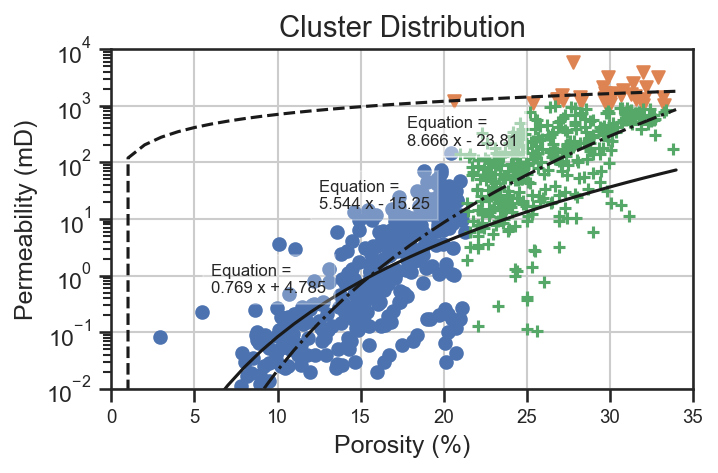

In [39]:
fs = 12

#markers - https://matplotlib.org/stable/api/markers_api.html
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5,3), dpi = 150,)
plt.scatter(filtered_label0['Porosity (%)'], filtered_label0['K_klin (mD)'], marker='o')
plt.scatter(filtered_label1['Porosity (%)'], filtered_label1['K_klin (mD)'], marker='v')
plt.scatter(filtered_label2['Porosity (%)'], filtered_label2['K_klin (mD)'], marker='+')
#plt.scatter(filtered_label3['Porosity (%)'], filtered_label3['K_klin (mD)'], marker='s')

x_pts = list(range(0,35,1))

#Line styles - https://matplotlib.org/2.0.2/api/lines_api.html
p = np.polyfit(np.log(filtered_label0['Porosity (%)']), np.log(filtered_label0['K_klin (mD)']), 1)
f = np.poly1d(p)
plt.semilogy(x_pts, np.exp(p[0] * np.log(x_pts) + p[1]), 'k-', linewidth = 1.5)
plt.text(12.5, 15, r'Equation ={}'.format(f), fontsize = fs/1.5, bbox=dict(facecolor='white', alpha=0.25))

p = np.polyfit(np.log(filtered_label1['Porosity (%)']), np.log(filtered_label1['K_klin (mD)']), 1)
f = np.poly1d(p)
plt.semilogy(x_pts, np.exp(p[0] * np.log(x_pts) + p[1]), 'k--', linewidth = 1.5)
plt.text(6, 0.5, r'Equation ={}'.format(f), fontsize = fs/1.5, bbox=dict(facecolor='white', alpha=0.25))

p = np.polyfit(np.log(filtered_label2['Porosity (%)']), np.log(filtered_label2['K_klin (mD)']), 1)
f = np.poly1d(p)
plt.semilogy(x_pts, np.exp(p[0] * np.log(x_pts) + p[1]), 'k-.', linewidth = 1.5)
plt.text(17.8, 200, r'Equation ={}'.format(f), fontsize = fs/1.5, bbox=dict(facecolor='white', alpha=0.5))

# p = np.polyfit(np.log(filtered_label3['Porosity (%)']), np.log(filtered_label3['K_klin (mD)']), 1)
# f = np.poly1d(p)
# plt.semilogy(filtered_label3['Porosity (%)'], np.exp(p[0] * np.log(filtered_label3['Porosity (%)']) + p[1]), 'k.', linewidth = 1.5)
# plt.text(17.8, 200, r'Equation ={}'.format(f), fontsize = fs/1.5, bbox=dict(facecolor='white', alpha=0.5))

plt.yscale('log')
plt.xlim(0, xlimit)
plt.ylim(0.01, ylimit)
plt.xticks(fontsize=fs-3)
plt.xlabel('Porosity (%)',fontsize=fs)
plt.ylabel('Permeability (mD)',fontsize=fs)
plt.title('Cluster Distribution',fontsize=fs+2)
plt.grid(True)

plt.savefig('Cluster_Dist.png', transparent=True)

In [40]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))

Completed Process in 13.527589797973633 seconds
